<a href="https://colab.research.google.com/github/bensong04/PredictivNet/blob/main/predictivbnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3.9 -m pip install torchbnn
!python3.9 -m pip install seaborn
!python3.9 -m pip install scipy

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no 

In [ ]:
import sys
sys.path.append('.')
sys.path.append('./BCNN')
sys.path.append('./BCNN/layers')
sys.path.append('/bayesian-neural-network-pytorch')

import torch.nn as nn
import torch.optim as optim
import torch.autograd
import pandas as pd
import numpy as np
'''
from BBB_LRT.BBBLinear import BBBLinear as BLinear2d
from misc import ModuleWrapper as ModuleWrapper, FlattenLayer as FlattenLayer
'''
from torch.utils.data import DataLoader as Loader, IterableDataset as Dataset
import torchbnn as bnn
from typing import Iterator
from itertools import tee
import copy
import math
import scipy.stats

In [ ]:

class PredictivNet(nn.Module):
  def __init__(self, inputs, priors=None, l1=1000, l2=500, activation='softplus'):
    super(PredictivNet, self).__init__()

    if activation=='softplus':
      self.act = nn.Softplus
    elif activation=='relu':
      self.act = nn.ReLU
    else:
      raise ValueError("Only softplus or relu supported")

    self.priors = priors
    if self.priors == None:
      self.priors = {'mu': 0.5, 's': 0.1}

    self.layer1 = bnn.BayesLinear(prior_mu=self.priors['mu'], prior_sigma=self.priors['s'],
      in_features=inputs, out_features=l1)
    self.act1 = self.act()
    
    self.layer2 = bnn.BayesLinear(prior_mu=self.priors['mu'], prior_sigma=self.priors['s'],
      in_features=l1, out_features=l2)
    self.act2 = self.act()
    
    self.layer3 = bnn.BayesLinear(prior_mu=self.priors['mu'], prior_sigma=self.priors['s'],
      in_features=l2, out_features=1) # Quantitative data
    self.act3 = self.act()
  
  def forward(self, x):
    x1 = self.act1(self.layer1(x))
    x2 = self.act2(self.layer2(x1))
    return abs(self.layer3(x2))


In [ ]:
class GlioblastomaDataset(Dataset):
  def __init__(self, raw_set: pd.DataFrame):
    # Skip over race for now
    # Gender should not be skipped over!
    raw_set = raw_set.reset_index(drop=True)
    raw_set = raw_set.drop(['ID', '6 Month', '6rounded', 'Race'], axis=1)
    def gender_vec(g):
      if g.lower()=="male":
        return 0
      else:
        return 1
    '''
    def race_vec(r):
      r = r.strip()
      if r=="African American":
        return 0
      elif r=="Asian":
        return 0.5
      elif r=="Caucasian":
        return 1
      else:
        raise ValueError("Unrecognized race {}".format(r))
    '''
    gender_vec = np.vectorize(gender_vec)
    '''race_vec = np.vectorize(race_vec)'''
    raw_set['Gender'] = gender_vec(raw_set['Gender'])
    '''raw_set['Race'] = race_vec(raw_set['Race'])'''
    raw_set['Age at Diagnosis '] = raw_set['Age at Diagnosis '].div(100)
    raw_set['Days Till Death'] = raw_set['Days Till Death'].div(1000)
    self.T = raw_set.T
    self.curr = 0
  def __next__(self):
    '''
    A map-style dataset is expensive; we should implement __iter__ protocol instead.
    '''
    # Gets the first row (column of transpose) converts to 
    # 1D np.array.
    try:
      newItem = self.T[self.curr]
    except KeyError:
      raise StopIteration
    self.curr += 1
    daysTillDeath = np.array(newItem['Days Till Death'], dtype=float)
    newItem = newItem.drop(['Days Till Death'])
    newItem = newItem.reset_index(drop=True)
    arr = newItem.to_numpy(dtype=float)

    #print(arr, daysTillDeath)
    return arr, daysTillDeath
  def __iter__(self):
    return self

In [ ]:
def train(ds, valds, model, optimizer, epochs,):
  epoch = 0
  loss_fn = nn.MSELoss()
  loss_kl = bnn.BKLLoss(reduction='mean', last_layer_only=False)
  ds = list(ds)
  valds = list(valds)

  loss_per_epoch = {}
  vloss_per_epoch = {}

  while epoch < epochs:
    dataset = ds
    epoch += 1

    running_loss = 0.
    running_vloss = 0.
    last_loss = 0.

    # Here, we use enumerate(dataset) instead of
    # iter(dataset) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dataset):
        #print(i)
        #print(data)
        # Every data instance is an input + label pair

        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.float())

        # Compute the loss and its gradients
        outputs = torch.reshape(outputs, (-1,))
        #print(outputs)
    
        loss = loss_fn(outputs, labels.float())
        b_loss = loss_kl(model)
        tot_loss = loss + (0.10 * b_loss)
        tot_loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += tot_loss.item()
        if i % 50 == 49:
            last_loss = running_loss / 50 
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
    
    for j, vdata in enumerate(valds):
        vinputs, vlabels = vdata
        voutputs = model(vinputs.float())
        voutputs = torch.reshape(voutputs, (-1,))
        vloss = loss_fn(voutputs.float(), vlabels.float())
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('EPOCH {} LOSS train {} valid {}'.format(epoch, last_loss, avg_vloss))

    loss_per_epoch[epoch] = last_loss
    vloss_per_epoch[epoch] = avg_vloss
  
  return loss_per_epoch, vloss_per_epoch




In [ ]:
#torch.autograd.detect_anomaly()

model = PredictivNet(inputs=502)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.0005)

ds = GlioblastomaDataset(pd.read_csv("/Users/bensong/Downloads/GlioblastomaData.csv")[:150]) # only first 150 rows
valds = GlioblastomaDataset(pd.read_csv("/Users/bensong/Downloads/GlioblastomaData.csv")[151:200])
dl = Loader(ds, batch_size=1)
valdl = Loader(valds, batch_size=1)

ld, vld = train(dl, valdl, model, optimizer, epochs=70)

NameError: ignored

In [ ]:
PATH = '/Users/bensong/Downloads/predictivnetgendercheckptsession3.pth'

model = PredictivNet(inputs=501)
model.load_state_dict(torch.load(PATH))
model.eval()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.0005)
ds = GlioblastomaDataset(pd.read_csv("/Users/bensong/Downloads/GlioblastomaData.csv")[:150]) # only first 150 rows
valds = GlioblastomaDataset(pd.read_csv("/Users/bensong/Downloads/GlioblastomaData.csv")[151:200])
dl = Loader(ds, batch_size=1)
valdl = Loader(valds, batch_size=1)

ld, vld = train(dl, valdl, model, optimizer, epochs=70)



  batch 50 loss: 2.0587742829322817
  batch 100 loss: 1.5112072801589966
  batch 150 loss: 1.456396188735962
EPOCH 1 LOSS train 1.456396188735962 valid 0.03858242183923721
  batch 50 loss: 1.7448637175559998
  batch 100 loss: 1.594786491394043
  batch 150 loss: 1.4859563136100769
EPOCH 2 LOSS train 1.4859563136100769 valid 0.09114548563957214
  batch 50 loss: 1.4905893588066101
  batch 100 loss: 1.5479099035263062
  batch 150 loss: 1.4447667026519775
EPOCH 3 LOSS train 1.4447667026519775 valid 0.04977576807141304
  batch 50 loss: 1.7679001212120056
  batch 100 loss: 1.4845809388160705
  batch 150 loss: 1.5448439335823059
EPOCH 4 LOSS train 1.5448439335823059 valid 0.07296305149793625
  batch 50 loss: 1.7490428829193114
  batch 100 loss: 1.5258649682998657
  batch 150 loss: 1.5026537656784058
EPOCH 5 LOSS train 1.5026537656784058 valid 0.0714724212884903
  batch 50 loss: 1.8924315404891967
  batch 100 loss: 1.47150892496109
  batch 150 loss: 1.4840593433380127
EPOCH 6 LOSS train 1.48405

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70)
(1.456396188735962, 1.4859563136100769, 1.4447667026519775, 1.5448439335823059, 1.5026537656784058, 1.4840593433380127, 1.4424964451789857, 1.5137417125701904, 1.5351905417442322, 1.555293607711792, 1.519601411819458, 1.4852324032783508, 1.483589448928833, 1.449278349876404, 1.5613787245750428, 1.5062343215942382, 1.5291317439079284, 1.4863948130607605, 1.3729965686798096, 1.4326312780380248, 1.5003665280342102, 1.4792029762268066, 1.6292367696762085, 1.4822012376785278, 1.5163403964042663, 1.4379431295394898, 1.4470667600631715, 1.4425694823265076, 1.4353319954872132, 1.4554187631607056, 1.4238352513313293, 1.524376060962677, 1.4705739617347717, 1.3909114027023315, 1.4832502961158753, 1.486887390613556, 1.409945023059

<AxesSubplot: xlabel='epoch', ylabel='loss'>

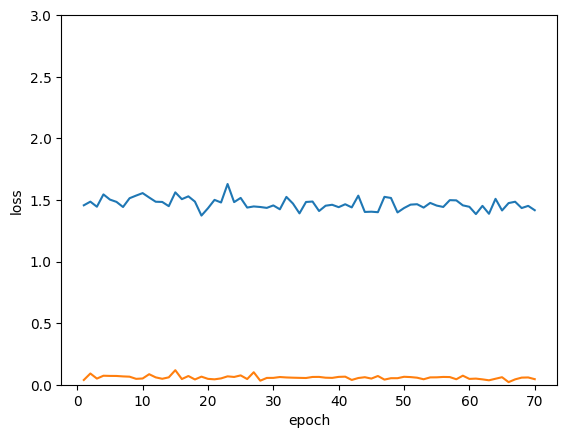

In [ ]:
import seaborn
import matplotlib.pyplot as plt

plt.ylim(0, 3)

epochs, losses = zip(*ld.items())
vepochs, vlosses = zip(*vld.items())
assert epochs == vepochs
print(epochs)
print(losses)
vlosses = tuple((ten.item() for ten in vlosses))
print(vlosses)
graphframe = pd.DataFrame({'epoch': pd.Series(epochs), 'loss': pd.Series(losses), 'validation loss': pd.Series(vlosses)})
seaborn.lineplot(data=graphframe, x='epoch', y='loss')
seaborn.lineplot(data=graphframe, x='epoch', y='validation loss')

In [ ]:
PATH = '/Users/bensong/Downloads/predictivnetgendercheckptsession4.pth'

model = PredictivNet(inputs=501)
model.load_state_dict(torch.load(PATH))
model.eval()

acc_test_ds = GlioblastomaDataset(pd.read_csv('/Users/bensong/Downloads/GlioblastomaData.csv')[201:271])
acc_test_ds = list(acc_test_ds)
acc_outputs = pd.DataFrame(data={'data point id' : pd.Series(), 'predicted longevity 99% confidence interval (days)' : pd.Series(), 'true value' : pd.Series()})
for i, items in enumerate(acc_test_ds):
  acc_test, true_val = items
  for j in range(0, 60): # take 60 samples from model
    #print(acc_test)
    prediction = model(torch.tensor(acc_test).float())
    #print(prediction)
    prediction = torch.reshape(prediction, (-1,))[0].item()
    actual = np.reshape(true_val, (-1,))[0]
    acc_outputs.loc[j+60*i] = {'data point id' : i, 'predicted longevity 99% confidence interval (days)' : prediction*1000, 'true value' : true_val*1000}



/var/folders/mm/g7nxxk691ks5fx52fj9shbc40000gn/T/ipykernel_45917/1853841940.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  acc_outputs = pd.DataFrame(data={'data point id' : pd.Series(), 'predicted longevity 99% confidence interval (days)' : pd.Series(), 'true value' : pd.Series()})
/var/folders/mm/g7nxxk691ks5fx52fj9shbc40000gn/T/ipykernel_45917/1853841940.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  acc_outputs = pd.DataFrame(data={'data point id' : pd.Series(), 'predicted longevity 99% confidence interval (days)' : pd.Series(), 'true value' : pd.Series()})
/var/folders/mm/g7nxxk691ks5fx52fj9shbc40000gn/T/ipykernel_45917/1853841940.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future versio

<AxesSubplot: xlabel='data point id', ylabel='true value'>

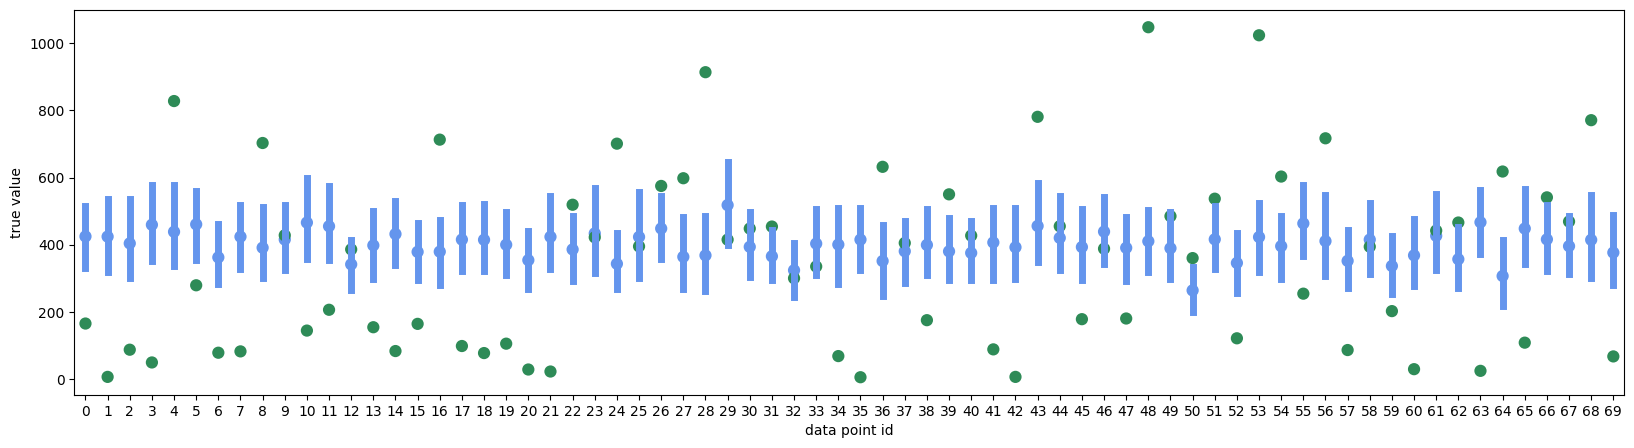

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)

seaborn.pointplot(data=acc_outputs, x='data point id', y='predicted longevity 99% confidence interval (days)', 
                 errorbar=('ci', 99), errwidth=5, color='cornflowerblue', join=False)
seaborn.pointplot(data=acc_outputs, x='data point id', y='true value', color='seagreen', join=False)


In [ ]:
def mean_confidence_interval(data, confidence=0.97):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

tot_catch = 0
tot_under = 0
tot_over = 0
conf_interval_w_avg = 0
min_long = 1000
max_long = 0
deltas = []

for id in range(0,70):
  df_for_id = acc_outputs[acc_outputs['data point id'] == id]
  mu, confl, confu = mean_confidence_interval(df_for_id['predicted longevity 99% confidence interval (days)'])
  try:
    true_long = df_for_id['true value'][id*60] # first point is the same as all the others
  except KeyError:
    print(id*60)
    print(df_for_id['true value'])
    raise
  if true_long < min_long:
    min_long = true_long
  if true_long > max_long:
    max_long = true_long
  if true_long > confu:
    tot_under += 1
  elif true_long < confl:
    tot_over += 1
  else:
    assert true_long >= confl and true_long <= confu
    tot_catch += 1
  conf_interval_w_avg += confu - confl
  deltas.append(mu-true_long)

conf_interval_w_avg /= 70
print("Total caught by 97% confidence interval: {} total overestimated: {} total underestimated: {}".format(tot_catch, tot_over, tot_under))
print("Average width of confidence intervals: {}".format(conf_interval_w_avg))
print("Minimum longevity: {} maximum longevity: {}".format(min_long, max_long))
print("Proportion caught by confidence interval: {} expected {}".format(tot_catch/70, conf_interval_w_avg/(max_long-min_long)))
prob = conf_interval_w_avg/(max_long-min_long)
print("Heuristic p-value from binomial cdf: {}".format(math.comb(70, tot_catch)*(prob**tot_catch)*(1-prob)**(70-tot_catch)))

Total caught by 97% confidence interval: 15 total overestimated: 32 total underestimated: 23
Average width of confidence intervals: 178.02676951315286
Minimum longevity: 5.0 maximum longevity: 1048.0
Proportion caught by confidence interval: 0.21428571428571427 expected 0.17068721909218873
Heuristic p-value from binomial cdf: 0.07425906458595012


<AxesSubplot: >

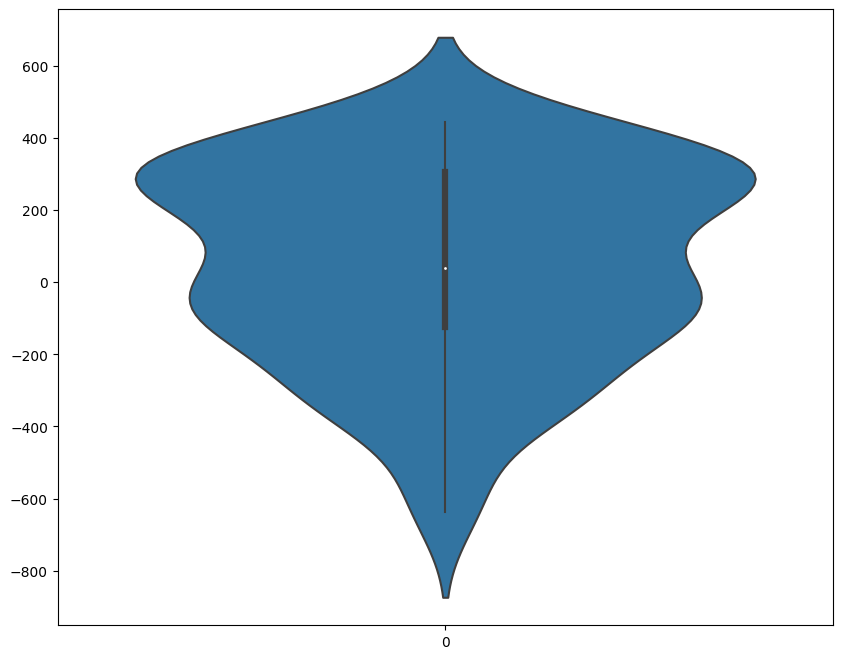

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
seaborn.violinplot(data=deltas)

In [ ]:
races = pd.read_csv("/Users/bensong/Downloads/GlioblastomaData.csv")['Race']
races = set(list(races))
print(races)

{nan, 'African American', 'Caucasian ', 'Asian', 'African American '}


In [ ]:
import torch
torch.save(model.state_dict(), '/Users/bensong/Downloads/predictivnetgendercheckptsession4.pth')
 